In [1]:
import torch
import numpy as np
import torch.nn as nn

if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev) 

In [2]:
features = torch.load('batched_data\\features').to(device).to(torch.float32)
labels = torch.load('batched_data\\labels').to(device).to(torch.float32)

In [3]:
print(features.shape)
print(labels.shape)

torch.Size([6977, 17280, 2])
torch.Size([6977, 17280])


In [4]:
class model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(model, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, 
                            bias=True, batch_first=True, dropout=0.0, 
                            bidirectional=False, proj_size=0, device=device, 
                            dtype=None)
        
        self.linear = nn.Linear(hidden_size, 1)
        self.softMax = nn.LogSoftmax(dim=1)

        self.series_length = 17280

    def forward(self, x):
        x, _ = self.lstm(x)

        x = self.stack(x)
        x = self.linear(x)
        x = self.unstack(x)

        x = self.softMax(x)
        return x

    def stack(self, x):
        x = x.reshape(x.shape[0] * self.series_length, x.shape[2])
        return x
    
    def unstack(self, x):
        x = x.reshape(x.shape[0] // self.series_length, self.series_length)
        return x

In [5]:
from torch import optim

inputSize = 2
hiddenSize = 4

lstm = model(inputSize, hiddenSize).to(device)
lossFunction = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr = 1e-3)


epoch:  1  loss:  9423.26887512207
epoch:  2  loss:  9409.760986328125
epoch:  3  loss:  9412.737121582031
epoch:  4  loss:  9413.938888549805
epoch:  5  loss:  9411.96688079834
epoch:  6  loss:  9411.318214416504
epoch:  7  loss:  9409.678260803223
epoch:  8  loss:  9409.227699279785


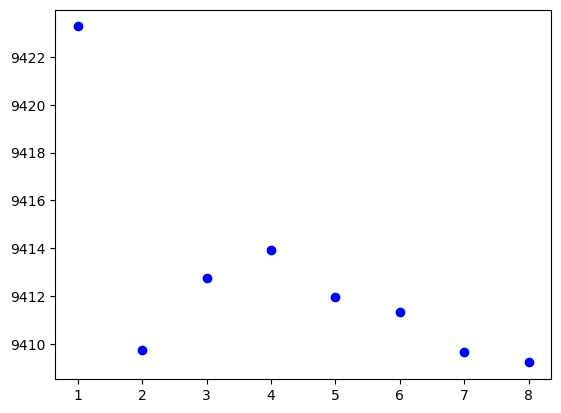

In [6]:
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

batch_size = 75
epochs = 8

train_dataset = TensorDataset(features, labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

for i in range(epochs):
    runningLoss = 0.0
    for x, y in train_dataloader:
        out = lstm(x)
    
        loss = lossFunction(out, y)
        
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        runningLoss += loss.detach().cpu().numpy()

    print("epoch: ", i + 1, " loss: ", runningLoss)
    plt.scatter(i + 1, runningLoss, color="b")
    
